In [ ]:
import os
import tensorflow as tf
import cv2 as cv
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Activation,Dropout,Lambda,Dense,Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.callbacks import EarlyStopping


from keras.utils.vis_utils import plot_model


In [3]:
def basic_preProcess(img):
    """
    Melakukan praproses dasar pada gambar dengan mengubah ukurannya ke dimensi standar.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dalam format BGR.

    Keluaran:
    ---------
    img : numpy.ndarray
        Gambar yang telah diubah ukurannya ke 224x224 piksel.

    Deskripsi:
    ------------
    Fungsi ini melakukan praproses dasar dengan mengubah ukuran gambar ke ukuran standar (224x224), 
    yang sesuai dengan persyaratan input untuk berbagai model pembelajaran mesin.
    """
    img = resize_image(img)
    return img

def resize_image(img):
  """
    Mengubah ukuran gambar ke dimensi yang diinginkan.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dalam format BGR.

    Keluaran:
    ---------
    img : numpy.ndarray
        Gambar yang telah diubah ukurannya ke dimensi (224, 224).

    Deskripsi:
    ------------
    Fungsi ini mengubah ukuran gambar ke dimensi tertentu menggunakan interpolasi linear untuk mempertahankan kualitas.
    Ukuran output standar adalah 224x224 piksel.
    """
  image_size = (224,224)
  img = cv.resize(img, image_size,interpolation = cv.INTER_LINEAR)
  return img

Preprocessing yang kami gunakan disini merupakan hasil dari testing dari beberapa algoritma maupun preprocess yang paling terbaik berdasarkan tabel di bawah ini : 

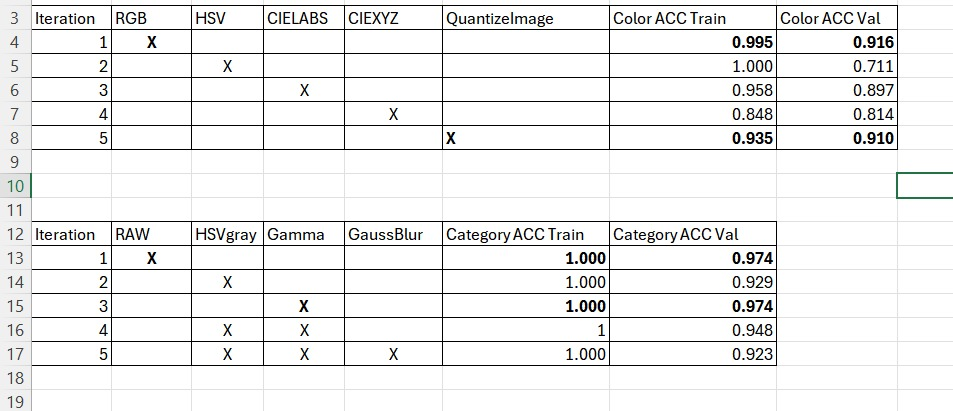

Tabel atas merupakan uji coba kami untuk model color dengan colorpsace maupun preprocess yang ada. 
Tabel yang bawah uji coba untuk model category dengan preprocess yang ada.

Untuk detail setiap preprocessnya akan berada di bagian bawah ini:

In [5]:
def color_preProcess(img):

  """
    Menerapkan serangkaian langkah praproses pada gambar untuk menyesuaikan warna dan isolasi foreground.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dalam format BGR.

    Keluaran:
    ---------
    img_rgb : numpy.ndarray
        Gambar hasil praproses dalam format RGB setelah melalui mean shift filtering, GrabCut, dan konversi ke RGB.

    Deskripsi:
    ------------
    Fungsi ini melakukan praproses pada gambar dengan menerapkan mean shift filtering untuk mengurangi noise dan 
    meningkatkan keseragaman warna, diikuti dengan isolasi foreground menggunakan GrabCut, dan mengonversi gambar 
    akhir ke format RGB.
    
    Langkah-langkah:
    1. **Mean Shift Filtering**: Menggunakan `meanShiftFilter()` untuk menghaluskan warna gambar dan mengurangi noise, sehingga menghasilkan warna yang lebih seragam.
    2. **Isolasi Foreground (GrabCut)**: Menggunakan `grabCut()` untuk memisahkan objek utama dalam gambar dari latar belakang. Proses ini membuat mask biner yang hanya menyisakan objek utama (foreground) dan menghilangkan latar belakang.
    3. **Konversi ke RGB**: Mengonversi gambar hasil isolasi ke format RGB menggunakan `to_RGB()` agar siap digunakan dalam aplikasi atau model yang membutuhkan format RGB.
    
    """
  
  # img = to_colorhsv(img)
  # img = to_CIELAB(img)
  # img = to_CIEXYZ(img)
  # img = quantize_image(img,8)
  mean_shift = meanShiftFilter(img)
  grab_cut = grabCut(mean_shift)
  img_rgb = to_RGB(grab_cut)


  return img_rgb

def grabCut (img):
    
    """
    Mengisolasi objek utama dalam gambar dengan menggunakan algoritma GrabCut.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dengan objek utama yang akan diisolasi.

    Keluaran:
    ---------
    foreground : numpy.ndarray
        Gambar dengan latar belakang diset menjadi hitam, hanya menyisakan objek utama.

    Deskripsi:
    ------------
    Fungsi ini menggunakan algoritma GrabCut dari OpenCV untuk memisahkan objek utama dari latar belakang.
    Fungsi ini membuat mask biner, di mana foreground diset ke 1 dan background diset ke 0.
    
    Langkah-langkah:
    1. **Inisialisasi Mask**: Membuat mask biner berukuran sama dengan gambar input, yang akan digunakan untuk membedakan foreground dan background.
    2. **Tentukan Rectangle Batas Foreground**: Membuat sebuah persegi (rectangle) pada gambar yang mengelilingi objek utama, yang akan digunakan oleh GrabCut sebagai area perkiraan awal objek.
    3. **Buat Model Background dan Foreground**: Menginisialisasi model untuk background dan foreground sebagai matriks nol yang akan diperbarui oleh algoritma GrabCut.
    4. **Penerapan GrabCut**: Menggunakan `cv.grabCut()` dengan mode `GC_INIT_WITH_RECT` untuk melakukan iterasi GrabCut pada gambar, mask, rectangle, dan model yang telah ditentukan. Algoritma ini mengidentifikasi dan memperbaiki area foreground dan background.
    5. **Buat Mask Biner**: Mengonversi mask hasil GrabCut menjadi biner dengan mengatur nilai mask menjadi 0 untuk background dan 1 untuk foreground.
    6. **Penerapan Mask pada Gambar**: Mengalikan gambar asli dengan mask biner untuk menghasilkan gambar dengan latar belakang hitam dan hanya menyisakan objek utama.

    """

    mask = np.zeros(img.shape[:2], np.uint8)

    rect = (8, 8, 224 -16, 224 -16)
    bgd_model = np.zeros((1, 65), np.float64)
    fgd_model = np.zeros((1, 65), np.float64) 
    cv.grabCut(img, mask, rect, bgd_model, fgd_model, 8, cv.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    foreground = img * mask2[:, :, np.newaxis]

    return foreground


def augment_contrast(image, lower=0.4, upper=1.4):
    """
    Mengatur kontras gambar secara acak dalam rentang tertentu.

    Parameter:
    -----------
    image : numpy.ndarray
        Gambar input yang ingin diatur kontrasnya.
    lower : float, optional
        Batas bawah rentang pengaturan kontras. Default adalah 0.4.
    upper : float, optional
        Batas atas rentang pengaturan kontras. Default adalah 1.4.

    Keluaran:
    ---------
    adjusted_image : numpy.ndarray
        Gambar dengan kontras yang telah diatur.

    Deskripsi:
    ------------
    Fungsi ini mengatur kontras gambar berdasarkan faktor acak dalam rentang yang diberikan.

    Langkah-langkah:
    1. **Pilih Faktor Kontras Secara Acak**: Menggunakan `np.random.uniform(lower, upper)` untuk memilih faktor kontras yang acak di antara batas bawah dan batas atas yang ditentukan.
    2. **Terapkan Penyesuaian Kontras**: Menggunakan `cv.convertScaleAbs()` dengan parameter `alpha` yang diatur ke faktor kontras yang dipilih dan `beta` diatur ke 0 untuk menerapkan penyesuaian kontras pada gambar.
    3. **Kembalikan Gambar yang Diperbarui**: Mengembalikan gambar hasil penyesuaian kontras yang telah diolah.
    """

    contrast_factor = np.random.uniform(lower, upper)
    
    adjusted_image = cv.convertScaleAbs(image, alpha=contrast_factor, beta=0)  # alpha controls contrast
    return adjusted_image

def meanShiftFilter(img):

  """
    Menggunakan filter mean shift untuk menghaluskan warna pada gambar.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input yang ingin dihaluskan.

    Keluaran:
    ---------
    mean_shift_result : numpy.ndarray
        Gambar yang telah diproses menggunakan filter mean shift.

    Deskripsi:
    ------------
    Fungsi ini menerapkan mean shift filtering pada gambar untuk mengurangi noise dan menghasilkan warna yang lebih halus.
    
    Langkah-langkah:
    1. Menentukan value untuk spatial_radius dan color_radius yang dimana spatial_radius dapat berguna untuk menentukan radius window sehingga berpengaruh untuk spatial smoothing. Color_radius berguna untuk window radius pada color sehingga berguna untuk intensitas mencocokan warnanya.
    2. Memasukkan parameter spatial_radius dan color_radius ke dalam cv.pyrMeanShiftfiltering
    3. Mengembalikan hasil mean_shift tersebut

    """
  
  spatial_radius = 20  # Higher value for more spatial smoothing
  color_radius = 10    # Higher value for more color similarity
  mean_shift_result = cv.pyrMeanShiftFiltering(img, sp=spatial_radius, sr=color_radius)
  return mean_shift_result

def to_colorhsv(img):
  """
    Mengubah gambar ke ruang warna HSV dan melakukan penyesuaian pada kanal nilai.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar dalam format HSV.

    Keluaran:
    ---------
    img : numpy.ndarray
        Gambar yang telah diubah ke format BGR dengan penyesuaian kanal.

    Deskripsi:
    ------------
    Fungsi ini mengatur nilai saturation, dan value pada gambar, lalu mengonversi kembali ke BGR.
    
      Langkah-langkah:
    1. **Tentukan Skala Saturasi dan Nilai**: Mengatur skala untuk saturasi (`saturation_scale`) dan nilai (`value_scale`). Dalam contoh ini, keduanya diatur ke 1 (tanpa perubahan).
    2. **Penyesuaian Saturasi**: Mengalikan kanal saturasi (indeks 1) dari gambar dengan `saturation_scale` dan membatasi nilainya menggunakan `np.clip()` agar tetap dalam rentang [0, 255].
    3. **Penyesuaian Nilai**: Mengalikan kanal nilai (indeks 2) dari gambar dengan `value_scale` dan membatasi nilainya juga menggunakan `np.clip()`.
    4. **Equalisasi Histogram Kanal Nilai**: Menggunakan `cv.equalizeHist()` pada kanal nilai untuk meningkatkan kontras.
    5. **Konversi Kembali ke BGR**: Mengonversi gambar yang telah disesuaikan dari ruang warna HSV ke ruang warna BGR menggunakan `cv.cvtColor()`.
    6. **Kembalikan Gambar yang Diperbarui**: Mengembalikan gambar yang telah diolah dalam format BGR.

    """
  
  saturation_scale = 1
  value_scale = 1

  img[..., 1] = np.clip(img[..., 1] * saturation_scale, 0, 255)
  img[..., 2] = np.clip(img[..., 2] * value_scale, 0, 255)
  img[..., 2] = cv.equalizeHist(img[..., 2])

  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)

  return img

def to_CIELAB(img):

  """
      Mengonversi gambar dari BGR ke ruang warna CIELAB.

      Parameter:
      -----------
      img : numpy.ndarray
          Gambar input dalam format BGR.

      Keluaran:
      ---------
      img : numpy.ndarray
          Gambar dalam ruang warna CIELAB.

      Deskripsi:
      ------------
      Fungsi ini mengubah gambar dari ruang warna BGR ke CIELAB.
    """

  img = cv.cvtColor(img,cv.COLOR_BGR2Lab)
  return img

def to_CIEXYZ(img):

  """
    Mengonversi gambar dari BGR ke ruang warna CIEXYZ.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dalam format BGR.

    Keluaran:
    ---------
    img : numpy.ndarray
        Gambar dalam ruang warna CIEXYZ.

    Deskripsi:
    ------------
    Fungsi ini mengubah gambar dari ruang warna BGR ke CIEXYZ.
    """

  img = cv.cvtColor(img,cv.COLOR_BGR2XYZ)
  return img

def to_RGB(img):

  """
    Mengonversi gambar dari BGR ke RGB.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dalam format BGR.

    Keluaran:
    ---------
    img : numpy.ndarray
        Gambar dalam format RGB.

    Deskripsi:
    ------------
    Fungsi ini mengubah gambar dari ruang warna BGR ke RGB.
  """

  img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
  return img


In [ ]:
def category_preProcess(img):
  """
    Menerapkan serangkaian praproses untuk kategori gambar dengan tujuan isolasi objek utama.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dalam format BGR.

    Keluaran:
    ---------
    grab_cut : numpy.ndarray
        Gambar hasil isolasi foreground menggunakan GrabCut.

    Deskripsi:
    ------------
    Fungsi ini melakukan praproses kategori pada gambar dengan menggunakan GrabCut untuk mengisolasi foreground, 
    sehingga objek utama dalam gambar dapat dipisahkan dari latar belakang.
    """
  # img = to_grayhsv(img)
  # img = gamma_correct_HSV(img)
  grab_cut = grabCut(img)
  return grab_cut


def to_grayhsv(img):
  """
    Mengonversi gambar ke warna abu-abu dalam ruang warna HSV dengan penyesuaian pada kanal saturasi dan nilai.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dalam format HSV.

    Keluaran:
    ---------
    img : numpy.ndarray
        Gambar dalam format BGR setelah penyesuaian pada kanal saturasi dan nilai serta penerapan CLAHE.

    Deskripsi:
    ------------
    Fungsi ini mengubah gambar ke warna abu-abu dalam ruang warna HSV dengan menurunkan saturasi dan menyesuaikan
    nilai kecerahan, kemudian menerapkan CLAHE (Contrast Limited Adaptive Histogram Equalization) pada kanal V
    untuk meningkatkan kontras.
  """
  saturation_scale = 0
  value_scale = 0.7

  img[..., 1] = np.clip(img[..., 1] * saturation_scale, 0, 255)
  img[..., 2] = np.clip(img[..., 2] * value_scale, 0, 255)
  clahe = cv.createCLAHE(clipLimit=3)
  img[..., 2] = clahe.apply(img[..., 2])


  img = cv.cvtColor(img, cv.COLOR_HSV2BGR)

  # img = cv.GaussianBlur(img,(3,3),0)

  return img

def gamma_correct_HSV(img):
  """
    Melakukan koreksi gamma pada kanal nilai dalam ruang warna HSV.

    Parameter:
    -----------
    img : numpy.ndarray
        Gambar input dalam format BGR.

    Keluaran:
    ---------
    corrected_image : numpy.ndarray
        Gambar yang telah dikoreksi gamma pada kanal nilai (V), dikonversi kembali ke format BGR.

    Deskripsi:
    ------------
    Fungsi ini mengubah gambar ke ruang warna HSV dan menerapkan koreksi gamma pada kanal nilai (V) untuk menyesuaikan 
    kecerahan. Fungsi menggunakan lookup table untuk koreksi gamma dan mengembalikan gambar dalam format BGR.
    """
  gamma = 1.25

  hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  H, S, V = cv.split(hsv_img)

  lookup_table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255 for i in np.arange(0, 256)]).astype("uint8")

  V_corrected = cv.LUT(V, lookup_table)
  corrected_hsv = cv.merge([H, S, V_corrected])
  corrected_image = cv.cvtColor(corrected_hsv, cv.COLOR_HSV2BGR)

  return corrected_image